In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [3]:
## Data loading
df = pd.read_csv("datos_ambientales_numericos.csv")
df = df[['temperatura', 'presion', 'humedad']]
df

,temperatura,presion,humedad
0,27.19,790.4434,25.17188
1,27.44,790.3516,24.77051
2,27.72,790.4346,24.71582
3,27.61,790.4080,24.66504
4,27.78,790.4640,24.65234
...,...,...,...
700,26.59,788.6235,23.09961
701,26.58,788.6169,23.08496
702,26.57,788.5771,23.09473
703,26.57,788.6313,23.08887


# Data preprocessing

In [4]:
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(df)

def sliding_timeseries(data, n_steps):
    x, y = [], []
    for i in range(n_steps, len(data)):
        x.append(data[i - n_steps:i, 1:])  ## regressors (pressure and humidity)
        y.append(data[i, 0])  ## taking temperature as target variable
    return np.array(x), np.array(y)

n_steps = 10
x, y = sliding_timeseries(scaled_data, n_steps)

x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, shuffle=False)

# LSTM model

In [5]:
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(x.shape[1], x.shape[2])))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(8, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))
model.summary()

2025-05-03 20:35:03.503238: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                17152     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 8)                 136       
                                                                 
 dense_3 (Dense)             (None, 4)                 36        
                                                                 
 dense_4 (Dense)             (None, 1)                 5         
                                                                 
Total params: 19,937
Trainable params: 19,937
Non-traina

2025-05-03 20:35:05.530022: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-03 20:35:05.533490: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-03 20:35:05.535578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [6]:
epochs = 50
batch_size = 32

model.compile(optimizer='adam', loss='mse')
history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test, y_test), verbose=0)

2025-05-03 20:35:06.980252: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-03 20:35:06.983468: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-03 20:35:06.986054: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

5/5 [==============================] - 0s 7ms/step


2025-05-03 20:35:26.611945: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-03 20:35:26.613140: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-03 20:35:26.614537: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

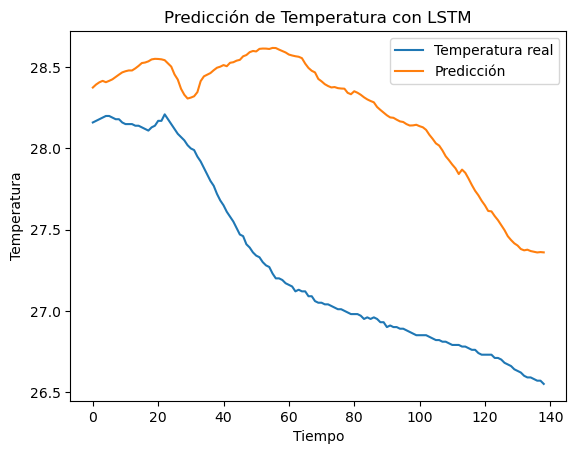

In [7]:
predicted = model.predict(x_test)
predicted_temp = scaler.inverse_transform(
    np.hstack((predicted, x_test[:, -1, :]))
)[:, 0]
real_temp = scaler.inverse_transform(
    np.hstack((y_test.reshape(-1,1), x_test[:, -1, :]))
)[:, 0]

plt.plot(real_temp, label='Temperatura real')
plt.plot(predicted_temp, label='Predicción')
plt.legend()
plt.title("Predicción de Temperatura con LSTM")
plt.xlabel("Tiempo")
plt.ylabel("Temperatura")
plt.show()

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential, save_model
from tensorflow.keras.layers import LSTM, Dense

tf.config.run_functions_eagerly(True)

def models(optimizers):
    histories = {}
    val_losses_finales = {}
    for optimizer in optimizers:
        model = Sequential()
        model.add(LSTM(64, return_sequences=False, input_shape=(x.shape[1], x.shape[2])))
        model.add(Dense(32, activation='relu'))
        model.add(Dense(16, activation='relu'))
        model.add(Dense(8, activation='relu'))
        model.add(Dense(4, activation='relu'))
        model.add(Dense(1))
        
        print(f"Optimizador: {optimizer}")
        model.compile(optimizer=optimizer, loss='mse')
        history = model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_test,y_test), verbose=0)
        
        histories[optimizer] = history.history['val_loss']
        val_losses_finales[optimizer] = history.history['val_loss'][-1]
    return histories, val_losses_finales


optimizers = ['Adam', 'SGD', 'RMSprop', 'Adagrad', 'Adadelta', 'Nadam']
histories, final_losses = models(optimizers)

2025-05-03 20:45:56.503492: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-03 20:45:56.505569: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-03 20:45:56.507900: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Optimizador: Adam


2025-05-03 20:46:44.698638: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-03 20:46:44.699876: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-03 20:46:44.701135: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Optimizador: SGD


2025-05-03 20:47:20.930845: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-03 20:47:20.931846: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-03 20:47:20.933159: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Optimizador: RMSprop


2025-05-03 20:47:59.922183: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-03 20:47:59.923319: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-03 20:47:59.924419: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Optimizador: Adagrad


2025-05-03 20:48:41.176449: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-03 20:48:41.177986: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-03 20:48:41.178947: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Optimizador: Adadelta


2025-05-03 20:49:36.765036: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2025-05-03 20:49:36.766128: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2025-05-03 20:49:36.767400: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Optimizador: Nadam


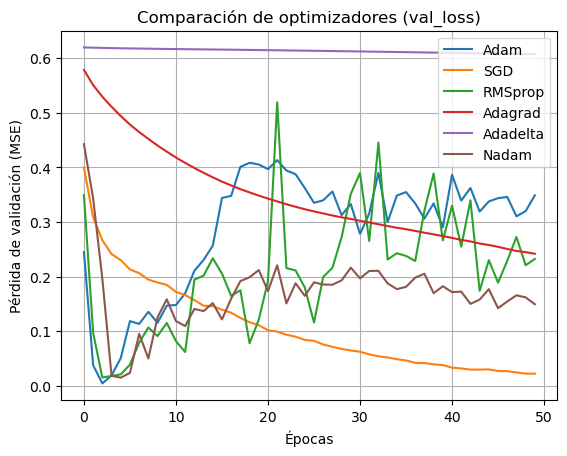


 Mejor optimizador: SGD


In [16]:
fig, ax = plt.subplots()
for nombre, val_loss in histories.items():
    ax.plot(val_loss, label=nombre)
ax.set_title('Comparación de optimizadores (val_loss)')
ax.set_xlabel('Épocas')
ax.set_ylabel('Pérdida de validación (MSE)')
ax.legend()
ax.grid(True)
plt.show()

mejor_optimizador = min(final_losses, key=final_losses.get)
print(f"\n Mejor optimizador: {mejor_optimizador}")